# Whittle- Matérn prior

The aim of this notebook is to show simulation of the Whittle-Matérn priors described in the paper 

*Calvetti and Somersalo (2017) Inverse problems: From regularization to Bayesian inference*



sent by Thomas

In [21]:
# Install the geostatistical package "gstlearn" (developped by our team)
# It is stored on incubator of python packages, so you have to uncomment the next line

# !pip install -i https://test.pypi.org/simple/ gstlearn

In [22]:
# !git clone git://github.com/scikit-sparse/scikit-sparse.git
# !sudo apt-get install python-scipy libsuitesparse-dev
# !pip install --user scikit-sparse

In [1]:
import gstlearn as gl
# import gstlearn.plot as gp

#sksparse is a little bit tricky to install
from sksparse.cholmod import cholesky

#common packages
import scipy as sc
from scipy.sparse import *
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def simulate(ranges = [5,10], variance = 10, param = 1, nx = [100,100],mu=2500):
    #Creation of the covariance model (Whittle-Matérn prior)
    model = gl.Model.createFromParam(gl.ECov.BESSEL_K,param = param,
                                     sill = variance, ranges = ranges)
    
    #Creation of the grid 
    mesh = gl.MeshETurbo(nx)
    
    #Creation of the precision matrix (inverse of the covariance)
    precisionOpMat = gl.PrecisionOpCs(mesh,model,0,gl.EPowerPT.ONE,False)
    Qtr = gl.csToTriplet(precisionOpMat.getQ())
    Qmat = sc.sparse.csc_matrix((np.array(Qtr.values), (np.array(Qtr.rows), np.array(Qtr.cols))))
    
    #Cholesky decomposition
    cholQ = cholesky(Qmat)
    
    #Random vector
    u = np.random.normal(size=np.prod(Qmat.shape[0]))
    
    # Apply the inverse of the Cholesky decomposition
    
    simu = cholQ.apply_Pt(cholQ.solve_DLt(u))
    
    #Return the simulation (reshaped)
    
    return simu.reshape(mesh.getGrid().getNXs())+mu, Qmat

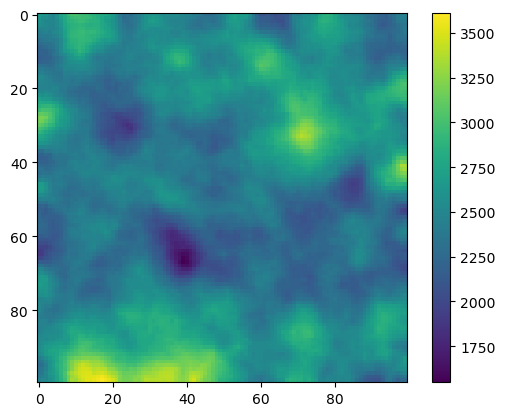

In [8]:
mu=2500
nz,nx = 100,100
simu, Q = simulate(ranges = [20,20],param=1,nx=[nz,nx],variance=500,mu=mu)
plt.imshow(simu)
a=plt.colorbar()

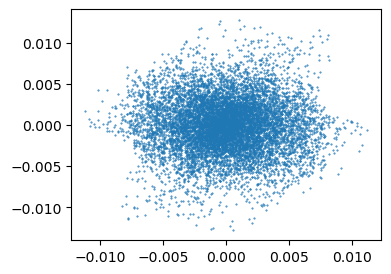

In [23]:
from sklearn.decomposition import PCA
# Create a precision matrix for the prior distribution
precision_matrix = Q.toarray()

# Perform PCA on the precision matrix
pca = PCA(n_components=2)
pc = pca.fit_transform(precision_matrix)

# Plot the first two principal components
plt.figure(figsize=(4,3))
plt.scatter(pc[:, 0], pc[:, 1],s=0.2)
plt.show()

## To do 

Play with the parameters **ranges** (use different values for the two components), **variance** and **param** (which has to be an integer)

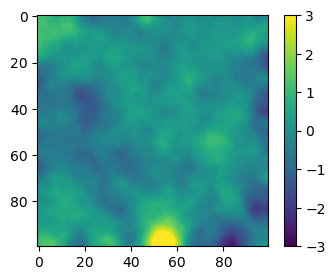

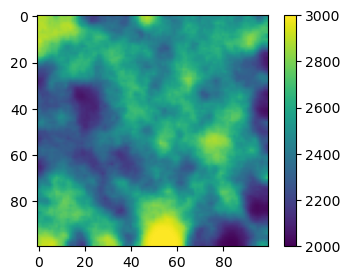

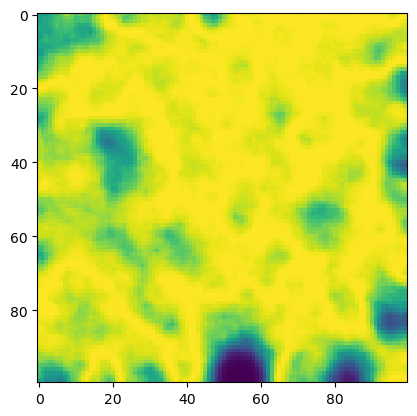

In [35]:
u = np.zeros([nz, nx])
u, _ = simulate(ranges = [20,20],param=1,nx=[nz,nx],variance=1,mu=0)
plt.figure(figsize=(4,3))
plt.imshow(u,vmin=-3,vmax=3)
plt.colorbar()
plt.show()

plt.figure(figsize=(4,3))
def f(u, vmin=2000, vmax=3000):
    # cdf of gaussian
    cdf = sc.stats.norm.cdf(u, loc=0, scale=1)
    v = (vmax-vmin)*cdf + vmin
    # # tanh
    # v = 500*np.tanh(u) + 2500
    # # sigmoid
    # sigmoid = 1/(1+np.exp(-u))
    # v = (vmax-vmin)*sigmoid + vmin

    return v.reshape((nz,nx))

v = f(u.flatten())
plt.imshow(v.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.show()

df = sc.misc.derivative(f,u)
# plt.imshow(df.reshape((nz,nx)))

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

import numpy as np

def sample_whittle_matern_prior(grid_size, length_scale, smoothness, n_samples):
    """
    Function to sample from a Whittle-Matérn prior using Cholesky decomposition
    """
    # Generate the covariance matrix
    cov = generate_whittle_matern_covariance(grid_size, length_scale, smoothness)
    # Perform Cholesky decomposition
    L = np.linalg.cholesky(cov)
    # Generate samples from the standard normal distribution
    samples = np.random.normal(size=(grid_size, n_samples))
    # Transform the samples to the prior distribution
    prior_samples = np.dot(L, samples)
    return prior_samples

def generate_whittle_matern_covariance(grid_size, length_scale, smoothness):
    """
    Function to generate the covariance matrix for the Whittle-Matérn prior
    """
    # Generate the distances between grid points
    distances = np.abs(np.arange(grid_size).reshape(-1, 1) - np.arange(grid_size))
    # Calculate the covariance for each pair of grid points
    cov = (2**(1-smoothness)) / np.math.gamma(smoothness) * (np.sqrt(2*smoothness) * distances / length_scale)**smoothness * np.exp(-np.sqrt(2*smoothness) * distances / length_scale)
    return cov

sample_whittle_matern_prior(10000,500,0.5,10)

LinAlgError: Matrix is not positive definite